In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import random
import math
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

# ODE Layer

In [2]:
class LinearODELayer(nn.Module):
    def __init__(self, in_features, out_features, bias=False):
        super(LinearODELayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.Tensor(self.out_features, self.in_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(self.out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
    # the forward step
    def forward(self, x):
        output = x.mm(self.weight)
        if self.bias is not None:
            output += self.bias
        return output
    # the backward function is not necessary, sincewe have only used
    # functions from pytorch (in particular, .reshape and .mm)
    
    # this function is inherited from the pytorch class Linear
    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)
            
#Thsi object can be extended
class NonLinearODELayer(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super(NonLinearODELayer, self).__init__()
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        self.weight = nn.Parameter(torch.Tensor(self.in_dim, self.hid_dim, self.out_dim))
        self.reset_parameters()
    
    def forward(self, x):
        xBx = x.matmul(self.weight).matmul(x.t()).permute(2,1,0)
        out = torch.diagonal(xBx).t()
        return out
    
    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))

# ODE Model

In [40]:
class LinearODEModel(nn.Module):
    def __init__(self, in_feature, out_feature, bias=False):
        super(LinearODEModel, self).__init__()
        self.in_feature = in_feature
        self.out_feature = out_feature
        self.bias = bias
        self.ode = LinearODELayer(self.in_feature, self.out_feature, self.bias)
        
    def forward(self, x):
        out = self.ode(x)
        return out
    
    
class NNODEModel(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, bias=False):
        super(NNODEModel, self).__init__()
        #Dimension
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        
        self.bias = bias
        
        #Layer 
        self.lin_ode = LinearODELayer(self.in_dim, self.out_dim, self.bias)
        self.nl_ode = NonLinearODELayer(self.in_dim, self.hid_dim, self.out_dim)
        
        #weight init
        self.reset_parameters()
        
    def forward(self, x):
        out = self.lin_ode(x) + self.nl_ode(x)
        return out
    
    def reset_parameters(self):
        self.lin_ode.weight.data.uniform_(-0.1,0.1)
        if self.bias:
            self.lin_ode.bias.data.uniform_(-0.1,0.1)
        self.nl_ode.weight.data.uniform_(-0.01,0.01)

# Utils

In [103]:
def train_model(model, train_x, train_y, loss_fn, optimizer, batch_size):
    train_loss = 0
    for b in range(0, train_x.size(0), batch_size):
        model.zero_grad()
        pred = model(train_x.narrow(0, b, batch_size))
        loss = loss_fn(pred, train_y.narrow(0, b, batch_size))
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    return train_loss



def generate_pendulum(k, sol, dt=1, T=100, dim=2):
    A = np.asarray([[0,1],[-k,0]])
    I = np.eye(dim)
    AA = (I + dt*A)
    for i in range(T):
        sol.append(np.dot(np.asarray(sol[-1]),AA))
    
    X = np.asarray(sol)[:-1]
    Y = np.asarray(sol)[1:]
    train_x = torch.FloatTensor(X)
    train_y = torch.FloatTensor(Y)
    return train_x, train_y, torch.Tensor(AA)


def generate_lorenz(sigma, rho, beta, sol, dt=0.01, T=10000, dim=3):
    A = np.asarray([[-sigma, sigma, 0], [rho, -1, 0], [0, 0, -beta]])
    Q0 = np.asarray([[0,0,0], [0,0,0], [0,0,0]])*dt
    Q1= np.asarray([[0,0,-1], [0,0,0], [0,0,0]])*dt
    Q2 = np.asarray([[0,1,0],[0,0,0], [0,0,0]])*dt
    
    B = np.array([Q0, Q1, Q2])

    I = np.eye(dim)
    AA = (I+dt*A)
    
    for i in range(T):
        x = np.asarray(sol[-1])
        Ax = AA.dot(x)
    
        phix = x.T.dot(B).dot(x)
    
        f = Ax + phix
        sol.append(f)
    
    X = np.asarray(sol)[:-1]
    Y = np.asarray(sol)[1:]
    train_x = torch.FloatTensor(X)
    train_y = torch.FloatTensor(Y)
    
    return train_x, train_y, torch.Tensor(A), torch.Tensor(B)

def training_session(model, train_x, train_y, lr=1e-2, n_print=10, n_epoch=100, batch_size=1, print_mat=False, print_feat=False):
    loss_fn = nn.MSELoss()
    optimizer = optim.Adagrad(model.parameters(), lr=lr)
    if print_mat:
        print('Initial weigths of the matrix:')
        print(list(model.parameters()))

    train_loss = []

    for epoch in range(n_epoch):
        loss = train_model(model, train_x, train_y, loss_fn, optimizer, batch_size)
        train_loss.append(loss)
        if print_feat:
            if epoch%n_print == 0:
                print('\n\n\nEpoch:', epoch+1, 'train_loss:', loss)
                print('weight:')
                print(list(model.parameters()))
    if print_mat:
        print('Final weigths of the matrix:')
        print(list(model.parameters()))
    weights = model.state_dict()
    lin_weight = weights['lin_ode.weight']
    nl_weight = weights['nl_ode.weight']
    if print_feat:
        plt.plot(train_loss)
        plt.show()
    return train_loss, lin_weight, nl_weight

def prediction(lin_weight, nl_weight, sol, T):
    lin_weight = np.array(lin_weight)
    nl_weight = np.array(nl_weight)
    for i in range(100):
        x = np.asarray(sol[-1])
        Ax = lin_weight.dot(x)
    
        phix = x.T.dot(nl_weight).dot(x)
    
        f = Ax + phix
        sol.append(f)
    return np.array(sol)

In [113]:
def grid_search(model, train_x, train_y, T, z_dim , noise=[0.,0.1,0.2,0.3,0.4,0.5], epoch=[100], batch_size=[10], lr=1e-2):
    results = []
    for std in noise:
        print('noise std:', std)
        for n_epoch in epoch:
            print('n_epoch:', n_epoch)
            for b in batch_size:
                print('batch_size:', b)
                norm_noise = torch.randn(T, z_dim)*std
                train_x_noise = train_x + norm_noise
                
                train_y_noise = train_y + norm_noise
                
                select_model = model
                train_loss, lin_weight, nl_weight = training_session(select_model, train_x_noise, train_y_noise, lr, 10, n_epoch, b)
                A = lin_weight.detach().numpy()
                print(A)
                B = nl_weight.detach().numpy()
                print(B)
                
                min_loss = train_loss[T-1]
                
                cross = {
                    'noise_std': std,
                    'n_epoch': n_epoch,
                    'batch_size': b,
                    'min_loss': min_loss,
                    'Linear': [A],
                    'Quadratic': [B]
                }
                
                results.append(cross)
                select_model.reset_parameters()
        
    return results

# Pendulum

## Data exploration

In [6]:
k = 0.01
sol = [[0.99,1]]
train_x, train_y, H = generate_pendulum(k, sol)
print('Parameter:')
print(H)
print('train_x size:', train_x.size())
print('train_y size:', train_y.size())

Parameter:
tensor([[ 1.0000,  1.0000],
        [-0.0100,  1.0000]])
train_x size: torch.Size([100, 2])
train_y size: torch.Size([100, 2])


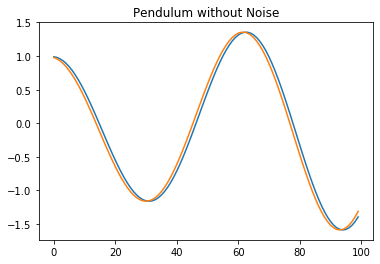

In [9]:
plt.plot(train_x[:,0].numpy());
plt.plot(train_y[:,0].numpy())
plt.title('Pendulum without Noise')
plt.show()

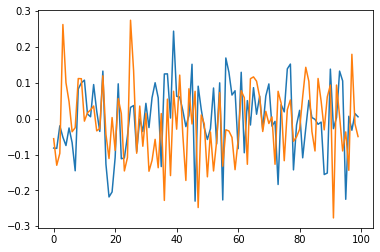

In [105]:
# Add noise to data
seed = 10
torch.manual_seed(10)
std = 0.1 #10% of the bound pendulum
noise = torch.randn(100,2)*std
plt.plot(noise.numpy())
plt.show()

In [106]:
train_x_noise = train_x + noise
train_y_noise = train_y + noise

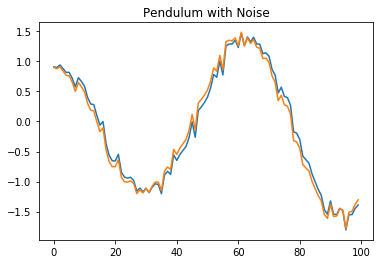

In [28]:
plt.plot(train_x_noise[:,0].numpy());
plt.plot(train_y_noise[:,0].numpy())
plt.title('Pendulum with Noise')
plt.show()

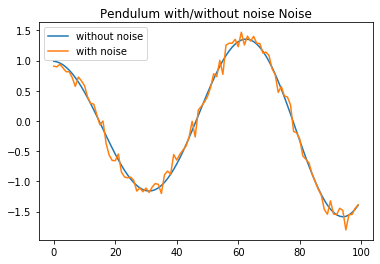

In [29]:
plt.plot(train_x[:,0].numpy(), label='without noise');
plt.plot(train_x_noise[:,0].numpy(), label='with noise')
plt.title('Pendulum with/without noise Noise')
plt.legend()
plt.show()

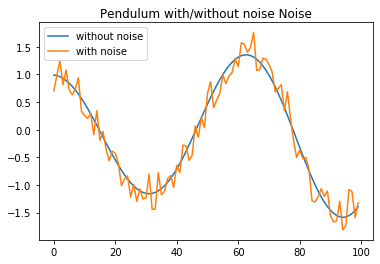

In [8]:
std = 0.2
noise2 = torch.randn(100,2)*std
train_x_noise2 = train_x + noise2
train_y_noise2 = train_y + noise2
plt.plot(train_x[:,0].numpy(), label='without noise');
plt.plot(train_x_noise2[:,0].numpy(), label='with noise')
plt.title('Pendulum with/without noise Noise')
plt.legend()
plt.show()

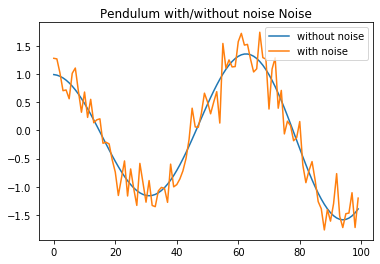

In [9]:
std = 0.3
noise3 = torch.randn(100,2)*std
train_x_noise3 = train_x + noise3
train_y_noise3 = train_y + noise3
plt.plot(train_x[:,0].numpy(), label='without noise');
plt.plot(train_x_noise3[:,0].numpy(), label='with noise')
plt.title('Pendulum with/without noise Noise')
plt.legend()
plt.show()

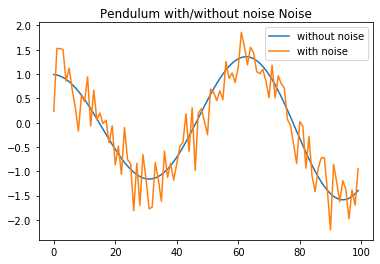

In [10]:
std = 0.4
noise4 = torch.randn(100,2)*std
train_x_noise4 = train_x + noise4
train_y_noise4 = train_y + noise4
plt.plot(train_x[:,0].numpy(), label='without noise');
plt.plot(train_x_noise4[:,0].numpy(), label='with noise')
plt.title('Pendulum with/without noise Noise')
plt.legend()
plt.show()

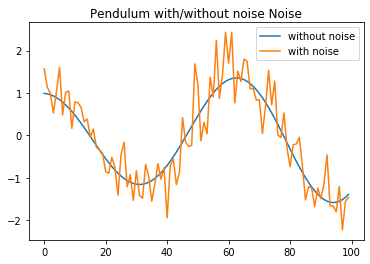

In [11]:
std = 0.5
noise5 = torch.randn(100,2)*std
train_x_noise5 = train_x + noise5
train_y_noise5 = train_y + noise5
plt.plot(train_x[:,0].numpy(), label='without noise');
plt.plot(train_x_noise5[:,0].numpy(), label='with noise')
plt.title('Pendulum with/without noise Noise')
plt.legend()
plt.show()

## Training the model: Explosion Analysis

In [114]:
# Add noise to data
seed = 10
torch.manual_seed(10)
epoch = [100, 200, 500, 600, 1000]
batch = [1, 10, 20, 50, 100]
noise=[0.,0.1,0.2,0.3,0.4,0.5]

model = NNODEModel(2,2,2)

grid_val = grid_search(model, train_x, train_y, 100, 2, noise, epoch, batch)

noise std: 0.0
n_epoch: 100
batch_size: 1
[[ 0.9306099   0.5590262 ]
 [-0.01184195  0.97677845]]
[[[-3.4470350e-02 -9.2603877e-04]
  [ 1.7272471e-03 -2.7307480e-05]]

 [[-8.1212915e-02  4.8590903e-03]
  [ 5.0826673e-03  9.3071477e-04]]]
batch_size: 10
[[ 0.3530521   0.19825672]
 [-0.0107642   0.47464082]]
[[[-0.0704824   0.00997432]
  [ 0.00947063 -0.00012293]]

 [[-0.03196103 -0.00520115]
  [-0.01712208  0.01757559]]]
batch_size: 20
[[ 0.29417676  0.21427664]
 [-0.00959988  0.3836812 ]]
[[[-0.05621408  0.01313551]
  [ 0.00842267 -0.00014955]]

 [[-0.02419536 -0.00268724]
  [-0.0134238   0.0204242 ]]]
batch_size: 50
[[ 0.27512187  0.23783624]
 [-0.00698844  0.21908762]]
[[[-0.134       0.00739301]
  [ 0.01179469  0.00050855]]

 [[-0.08570781 -0.02463423]
  [-0.02258887  0.02510264]]]
batch_size: 100
[[ 0.08894205  0.21165489]
 [-0.00708525  0.12721725]]
[[[-0.14436772  0.00966123]
  [ 0.0161927   0.00015604]]

 [[-0.13538752 -0.02608104]
  [-0.024127    0.02717974]]]
n_epoch: 200
batch

In [115]:
grid_df = pd.DataFrame(grid_val)

In [116]:
#Dataframe creation
grid_df

,noise_std,n_epoch,batch_size,min_loss,Linear,Quadratic
0,0.0,100,1,10.380778,"[[[-0.026361063, -0.060682632], [0.09520889, 0...","[[[[0.00534643 0.00333988], [ 0.00275624 -0.00..."
1,0.0,100,10,101.312415,"[[[-0.026361063, -0.060682632], [0.09520889, 0...","[[[[0.00534643 0.00333988], [ 0.00275624 -0.00..."
2,0.0,100,20,68.876836,"[[[-0.026361063, -0.060682632], [0.09520889, 0...","[[[[0.00534643 0.00333988], [ 0.00275624 -0.00..."
3,0.0,100,50,43.230295,"[[[-0.026361063, -0.060682632], [0.09520889, 0...","[[[[0.00534643 0.00333988], [ 0.00275624 -0.00..."
4,0.0,100,100,26.904974,"[[[-0.026361063, -0.060682632], [0.09520889, 0...","[[[[0.00534643 0.00333988], [ 0.00275624 -0.00..."
...,...,...,...,...,...,...
145,0.5,1000,1,24.735413,"[[[-0.026361063, -0.060682632], [0.09520889, 0...","[[[[0.00534643 0.00333988], [ 0.00275624 -0.00..."
146,0.5,1000,10,122.593865,"[[[-0.026361063, -0.060682632], [0.09520889, 0...","[[[[0.00534643 0.00333988], [ 0.00275624 -0.00..."
147,0.5,1000,20,71.847605,"[[[-0.026361063, -0.060682632], [0.09520889, 0...","[[[[0.00534643 0.00333988], [ 0.00275624 -0.00..."
148,0.5,1000,50,42.038857,"[[[-0.026361063, -0.060682632], [0.09520889, 0...","[[[[0.00534643 0.00333988], [ 0.00275624 -0.00..."


In [117]:
grid_val

[{'noise_std': 0.0,
  'n_epoch': 100,
  'batch_size': 1,
  'min_loss': 10.380778499675216,
  'Linear': [array([[-0.02636106, -0.06068263],
          [ 0.09520889,  0.06951744]], dtype=float32)],
  'Quadratic': [array([[[ 0.00534643,  0.00333988],
           [ 0.00275624, -0.00753046]],
   
          [[ 0.00987643, -0.00873766],
           [ 0.00582967,  0.00019805]]], dtype=float32)]},
 {'noise_std': 0.0,
  'n_epoch': 100,
  'batch_size': 10,
  'min_loss': 101.31241488456726,
  'Linear': [array([[-0.02636106, -0.06068263],
          [ 0.09520889,  0.06951744]], dtype=float32)],
  'Quadratic': [array([[[ 0.00534643,  0.00333988],
           [ 0.00275624, -0.00753046]],
   
          [[ 0.00987643, -0.00873766],
           [ 0.00582967,  0.00019805]]], dtype=float32)]},
 {'noise_std': 0.0,
  'n_epoch': 100,
  'batch_size': 20,
  'min_loss': 68.87683582305908,
  'Linear': [array([[-0.02636106, -0.06068263],
          [ 0.09520889,  0.06951744]], dtype=float32)],
  'Quadratic': [array([[[ 

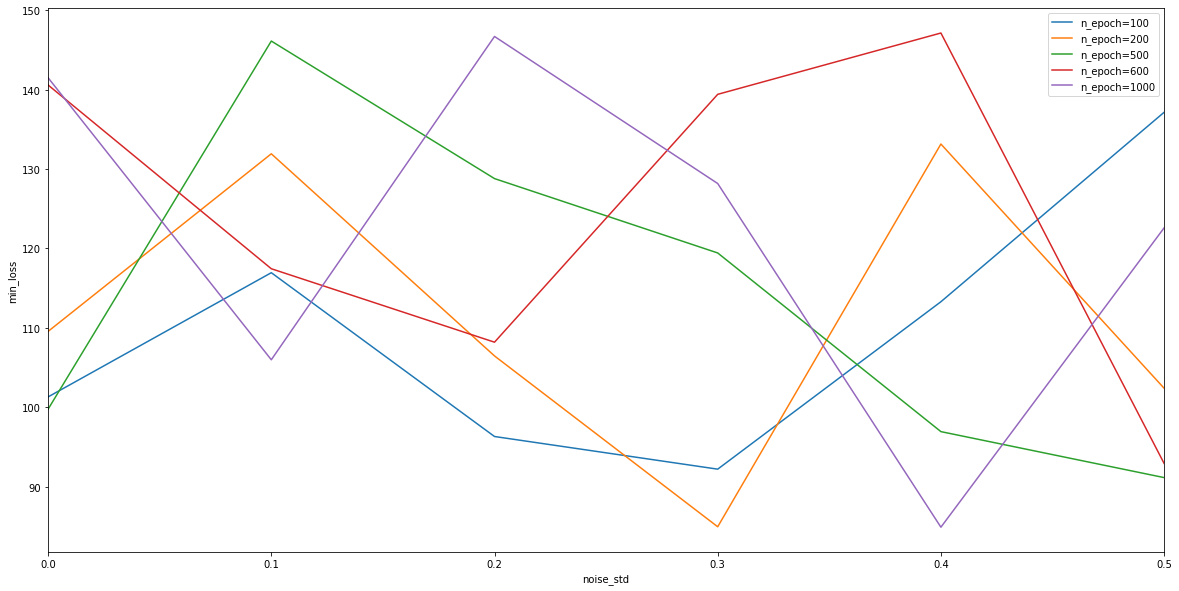

In [84]:
plt.figure(figsize=(20,10))
ax = plt.gca()
grid_df[(grid_df['n_epoch'] == 100) & (grid_df['batch_size'] == 10)].plot(kind='line', x='noise_std', y='min_loss', ax=ax, label='n_epoch=100')
grid_df[(grid_df['n_epoch'] == 200) & (grid_df['batch_size'] == 10)].plot(kind='line', x='noise_std', y='min_loss', ax=ax, label='n_epoch=200')
grid_df[(grid_df['n_epoch'] == 500) & (grid_df['batch_size'] == 10)].plot(kind='line', x='noise_std', y='min_loss', ax=ax, label='n_epoch=500')
grid_df[(grid_df['n_epoch'] == 600) & (grid_df['batch_size'] == 10)].plot(kind='line', x='noise_std', y='min_loss', ax=ax, label='n_epoch=600')
grid_df[(grid_df['n_epoch'] == 1000) & (grid_df['batch_size'] == 10)].plot(kind='line', x='noise_std', y='min_loss', ax=ax, label='n_epoch=1000')
plt.ylabel('min_loss')
plt.show()

For n_epoch = 100: We observe that the min loss increase from 0 to 0.1 according to the noise standard deviation, then decreases from 0.1 to 0.3 before increasing again.

For n_epoch = 200: Same behaviour as n_epoch = 100, in the exception that it increases from 0.3 to 0.4 and then decreases again.

For n_epoch = 500: Increase from 0 to 0.1 an then decreases.

For n_epoch = 600: decrease from 0 to 0.2, increase from 0.2 to 0.4 and then decreases.

For n_epoch = 1000: decrease from 0 to 0.1, increase to 0.2, decrease until 0.4 before increasing again.

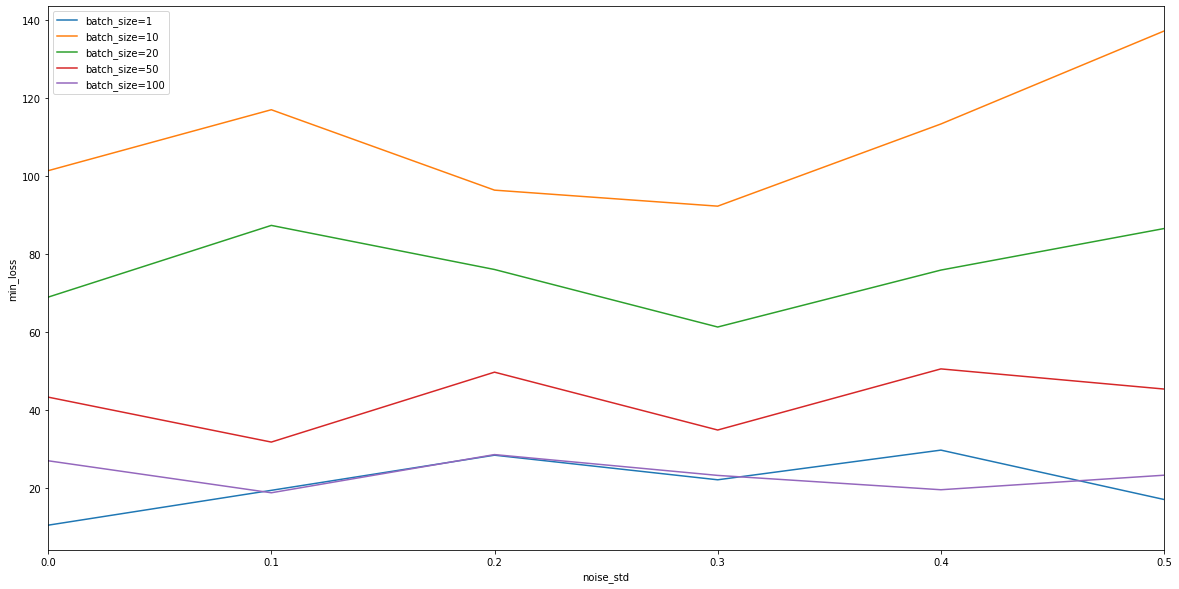

In [85]:
plt.figure(figsize=(20,10))
ax = plt.gca()
grid_df[(grid_df['n_epoch'] == 100) & (grid_df['batch_size'] == 1)].plot(kind='line', x='noise_std', y='min_loss', ax=ax, label='batch_size=1')
grid_df[(grid_df['n_epoch'] == 100) & (grid_df['batch_size'] == 10)].plot(kind='line', x='noise_std', y='min_loss', ax=ax, label='batch_size=10')
grid_df[(grid_df['n_epoch'] == 100) & (grid_df['batch_size'] == 20)].plot(kind='line', x='noise_std', y='min_loss', ax=ax, label='batch_size=20')
grid_df[(grid_df['n_epoch'] == 100) & (grid_df['batch_size'] == 50)].plot(kind='line', x='noise_std', y='min_loss', ax=ax, label='batch_size=50')
grid_df[(grid_df['n_epoch'] == 100) & (grid_df['batch_size'] == 100)].plot(kind='line', x='noise_std', y='min_loss', ax=ax, label='batch_size=100')
plt.ylabel('min_loss')
plt.show()

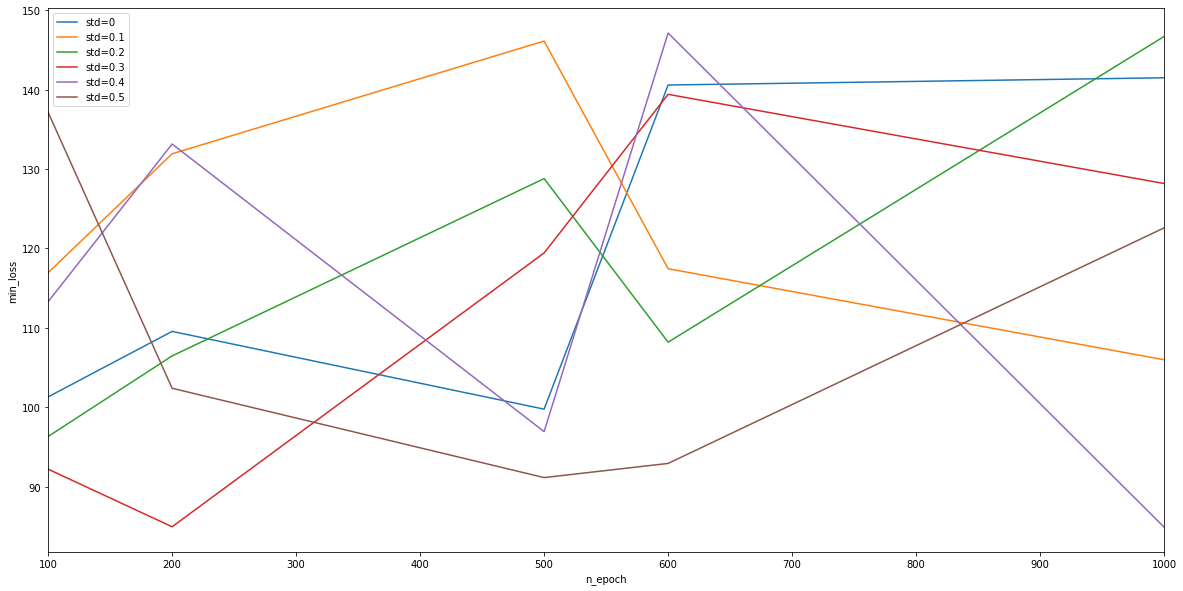

In [67]:
plt.figure(figsize=(20,10))
ax = plt.gca()
grid_df[(grid_df['noise_std']==0) & (grid_df['batch_size']==10)].plot(kind='line', x='n_epoch', y='min_loss', ax=ax, label='std=0')
grid_df[(grid_df['noise_std']==0.1) & (grid_df['batch_size']==10)].plot(kind='line', x='n_epoch', y='min_loss', ax=ax, label='std=0.1')
grid_df[(grid_df['noise_std']==0.2) & (grid_df['batch_size']==10)].plot(kind='line', x='n_epoch', y='min_loss', ax=ax, label='std=0.2')
grid_df[(grid_df['noise_std']==0.3) & (grid_df['batch_size']==10)].plot(kind='line', x='n_epoch', y='min_loss', ax=ax, label='std=0.3')
grid_df[(grid_df['noise_std']==0.4) & (grid_df['batch_size']==10)].plot(kind='line', x='n_epoch', y='min_loss', ax=ax, label='std=0.4')
grid_df[(grid_df['noise_std']==0.5) & (grid_df['batch_size']==10)].plot(kind='line', x='n_epoch', y='min_loss', ax=ax, label='std=0.5')
plt.ylabel('min_loss')
plt.show()

## Explosion point for Pendulum
## No noise

Initial matrix H:
tensor([[ 1.0000,  1.0000],
        [-0.0100,  1.0000]])
Initial weigths of the matrix:
[Parameter containing:
tensor([[0.0564, 0.0392],
        [0.0416, 0.0620]], requires_grad=True), Parameter containing:
tensor([[[ 0.0099,  0.0087],
         [ 0.0026, -0.0056]],

        [[-0.0084, -0.0092],
         [ 0.0063,  0.0036]]], requires_grad=True)]
Final weigths of the matrix:
[Parameter containing:
tensor([[ 0.9382,  0.5438],
        [-0.0117,  0.9699]], requires_grad=True), Parameter containing:
tensor([[[-2.8337e-02,  3.4671e-03],
         [-2.6343e-03, -2.8776e-05]],

        [[-6.7539e-02, -3.4164e-03],
         [ 1.2165e-02,  1.1290e-03]]], requires_grad=True)]


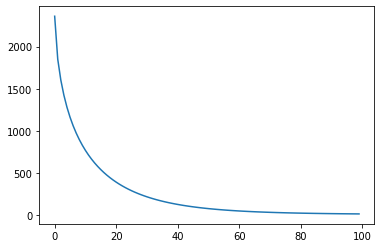

In [13]:
#without noise
print('Initial matrix H:')
print(H)

model = NNODEModel(2,2,2)

train_loss, lin_weight, nl_weight = training_session(model, train_x, train_y)

In [16]:
#Reconstruction of the data
sol = [[0.99,1]]
T = 100
pred = prediction(lin_weight, nl_weight, sol, T)

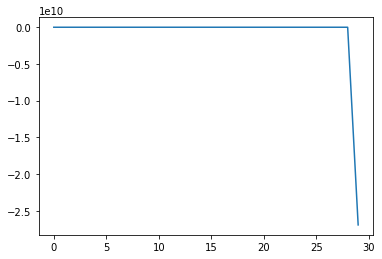

In [21]:
plt.plot(pred[0:30,0]);
plt.show()

Reconstruction of the model (without noise):

Explosion time point from 0 to 100: $t=30$

## Noise with std = 0.1

In [107]:
#with noise
print('Initial matrix H:')
print(H)

model = NNODEModel(2,2,2)
train_loss_noise, lin_weight, nl_weight = training_session(model, train_x_noise, train_y_noise)

Initial matrix H:
tensor([[ 1.0000,  1.0000],
        [-0.0100,  1.0000]])


In [33]:
#Reconstruction of the data
sol = [[0.99,1]]
T = 100
pred = prediction(lin_weight, nl_weight, sol, T)

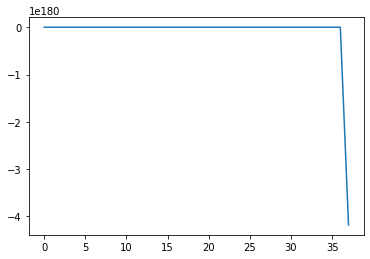

In [37]:
plt.plot(pred[0:40,0]);
plt.show()

Reconstruction of the model (noise with std=0.1):

Explosion time point from 0 to 100: $t=40$

## Noise with std=0.2

Initial matrix H:
tensor([[ 1.0000,  1.0000],
        [-0.0100,  1.0000]])
Initial weigths of the matrix:
[Parameter containing:
tensor([[-0.0347, -0.0858],
        [-0.0070, -0.0616]], requires_grad=True), Parameter containing:
tensor([[[ 0.0020,  0.0007],
         [-0.0073, -0.0066]],

        [[ 0.0083,  0.0056],
         [-0.0087,  0.0043]]], requires_grad=True)]
Final weigths of the matrix:
[Parameter containing:
tensor([[ 0.9075,  0.4135],
        [-0.0122,  0.9329]], requires_grad=True), Parameter containing:
tensor([[[-3.8746e-02,  4.8056e-03],
         [-3.2227e-03, -4.1064e-05]],

        [[-6.4993e-02,  1.1607e-02],
         [-2.6569e-03,  2.3450e-03]]], requires_grad=True)]


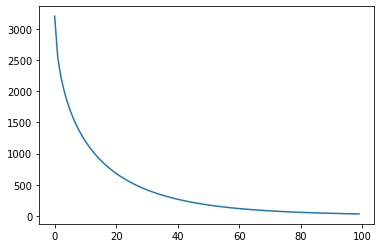

In [38]:
#noise with sigma=0.2
print('Initial matrix H:')
print(H)
model =  NNODEModel(2,2,2)
train_loss_noise2, lin_weight, nl_weight = training_session(model, train_x_noise2, train_y_noise2)

In [39]:
#Reconstruction of the data
sol = [[0.99,1]]
T = 100
pred = prediction(lin_weight, nl_weight, sol, T)

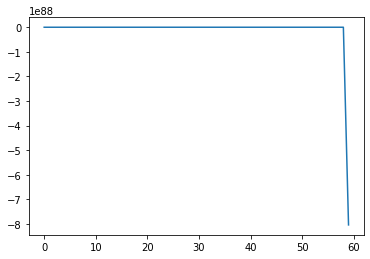

In [47]:
plt.plot(pred[0:60,0]);
plt.show()

Reconstruction of the model (noise with std=0.2):

Explosion time point from 0 to 100: $t=60$

## Noise with std = 0.3

Initial matrix H:
tensor([[ 1.0000,  1.0000],
        [-0.0100,  1.0000]])
Initial weigths of the matrix:
[Parameter containing:
tensor([[-0.0856,  0.0549],
        [ 0.0028, -0.0647]], requires_grad=True), Parameter containing:
tensor([[[ 0.0052,  0.0025],
         [-0.0041, -0.0037]],

        [[-0.0084,  0.0052],
         [ 0.0034, -0.0087]]], requires_grad=True)]
Final weigths of the matrix:
[Parameter containing:
tensor([[ 0.8860,  0.5007],
        [-0.0126,  0.9335]], requires_grad=True), Parameter containing:
tensor([[[-4.5280e-02,  4.3772e-03],
         [-2.1935e-03, -4.3616e-05]],

        [[-6.1820e-02,  3.9969e-03],
         [ 2.2156e-03,  2.3468e-03]]], requires_grad=True)]


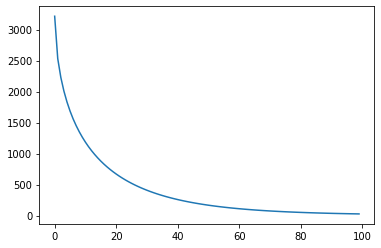

In [48]:
print('Initial matrix H:')
print(H)
model =  NNODEModel(2,2,2)
train_loss_noise3, lin_weight, nl_weight = training_session(model, train_x_noise3, train_y_noise3)

In [49]:
#Reconstruction of the data
sol = [[0.99,1]]
T = 100
pred = prediction(lin_weight, nl_weight, sol, T)

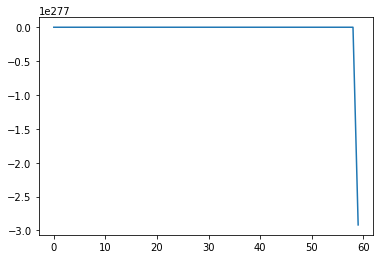

In [55]:
plt.plot(pred[0:60,0]);
plt.show()

Reconstruction of the model (noise with std=0.3):

Explosion time point from 0 to 100: $t=60$

## Noise with std=0.4

Initial matrix H:
tensor([[ 1.0000,  1.0000],
        [-0.0100,  1.0000]])
Initial weigths of the matrix:
[Parameter containing:
tensor([[-0.0212,  0.0933],
        [-0.0319,  0.0152]], requires_grad=True), Parameter containing:
tensor([[[-0.0081,  0.0032],
         [-0.0063, -0.0052]],

        [[-0.0089,  0.0036],
         [-0.0008,  0.0091]]], requires_grad=True)]
Final weigths of the matrix:
[Parameter containing:
tensor([[ 0.9122,  0.5548],
        [-0.0122,  0.9576]], requires_grad=True), Parameter containing:
tensor([[[-3.7630e-02,  5.4898e-03],
         [-4.0485e-03, -3.8616e-05]],

        [[-6.4520e-02,  5.7151e-03],
         [ 1.2417e-03,  1.5513e-03]]], requires_grad=True)]


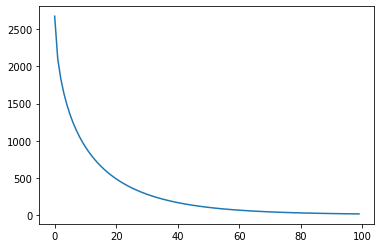

In [58]:
print('Initial matrix H:')
print(H)
model =  NNODEModel(2,2,2)
train_loss_noise4, lin_weight, nl_weight = training_session(model, train_x_noise4, train_y_noise4)

In [59]:
#Reconstruction of the data
sol = [[0.99,1]]
T = 100
pred = prediction(lin_weight, nl_weight, sol, T)

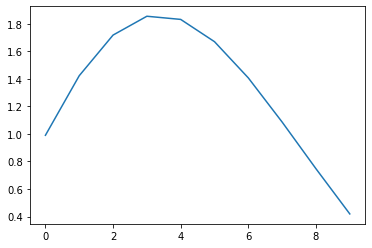

In [67]:
plt.plot(pred[0:10,0]);
plt.show()

Reconstruction of the model (noise with std=0.4):

Explosion time point from 0 to 100: $t=40$

## Noise with std=0.5

Initial matrix H:
tensor([[ 1.0000,  1.0000],
        [-0.0100,  1.0000]])
Initial weigths of the matrix:
[Parameter containing:
tensor([[0.0790, 0.0403],
        [0.0514, 0.0702]], requires_grad=True), Parameter containing:
tensor([[[-0.0038,  0.0022],
         [ 0.0064, -0.0061]],

        [[ 0.0072, -0.0093],
         [ 0.0021,  0.0063]]], requires_grad=True)]
Final weigths of the matrix:
[Parameter containing:
tensor([[ 0.9445,  0.5494],
        [-0.0115,  0.9716]], requires_grad=True), Parameter containing:
tensor([[[-2.6362e-02, -1.7980e-03],
         [ 2.4831e-03, -2.2506e-05]],

        [[-6.0788e-02, -1.3039e-03],
         [ 1.0071e-02,  1.0461e-03]]], requires_grad=True)]


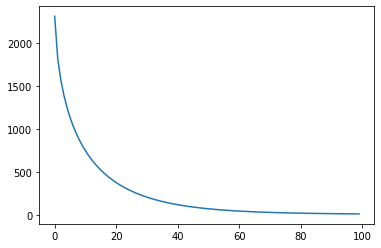

In [68]:
print('Initial matrix H:')
print(H)
model =  NNODEModel(2,2,2)
train_loss_noise5, lin_weight, nl_weight = training_session(model, train_x_noise5, train_y_noise5)

In [69]:
#Reconstruction of the data
sol = [[0.99,1]]
T = 100
pred = prediction(lin_weight, nl_weight, sol, T)

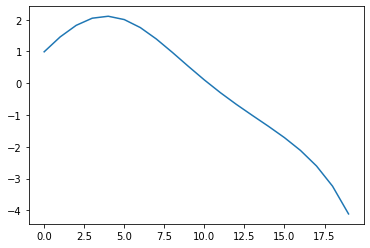

In [72]:
plt.plot(pred[0:20,0]);
plt.show()

Reconstruction of the model (noise with std=0.5):

Explosion time point from 0 to 100: $t=30$

# Analysis of the model

In [73]:
print('train_loss min:', train_loss[99])
print('train_loss_noise min:', train_loss_noise[99])
print('train_loss_noise2 min:', train_loss_noise2[99])
print('train_loss_noise3 min:', train_loss_noise3[99])
print('train_loss_noise4 min:', train_loss_noise4[99])
print('train_loss_noise5 min:', train_loss_noise5[99])

train_loss min: 12.689681535179261
train_loss_noise min: 20.926694257221243
train_loss_noise2 min: 32.06298375350889
train_loss_noise3 min: 27.950475619843928
train_loss_noise4 min: 15.853154807322426
train_loss_noise5 min: 12.09131604898721


# The test

29.11.2019:

data = pendulum

Explosion time:

std = 0, t=30

std = 0.1, t=40

std = 0.2, t=60

std = 0.3, t=60

std = 0.4, t=40

std = 0.5, t=30

--------------------------------------------------------------------------

# Real Data

In [18]:
data_path = '../data/'
data = pd.read_parquet(data_path+'SPY_hourly.parquet')

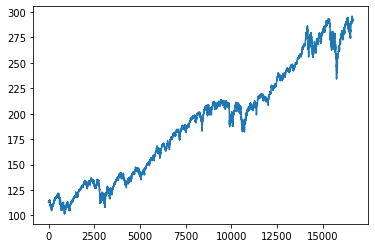

In [19]:
plt.plot(data.values)
plt.show()

In [20]:
spy=data.values.reshape((1,-1))[0]